# UC-Net: Uncertainty Inspired RGB-D Saliency Detection via Conditional Variational Autoencoders

This notebook works through the implementation of UC-Net, a network architecture that employs uncertainty for RGB-D saliency detection by learning from the data labelling process.

Standard RGB-D saliency detection methods treat the saliency detection task as a point estimation problem and produce a single saliency map following a deterministic learning pipeline. Inspired by the saliency data labelling process, UC-Net is a probabilistic RGB-D saliency detection network with a conditional variational autoencoder architecture that models human annotation uncertainty and generates multiple saliency maps for each input image by sampling in the latent space. With the proposed saliency consensus process, UC-Net generates an accurate saliency map based on these multiple predictions.

https://ieeexplore.ieee.org/document/9156838

In [ ]:
import os
import os.path
import pdb
import math
import gdown
import zipfile

from datetime import datetime

from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
from scipy import misc

import torch
import torch.nn as nn
from torch.nn import Parameter, Softmax
import torch.nn.functional as F

from torch.distributions import Normal, Independent, kl

from torch.autograd import Variable

from torch.distributions import Normal, Independent, kl

import torch.utils.data as data

import torchvision.models as models
import torchvision.transforms as transforms

!pip install torchviz
from torchviz import make_dot

# Data exploration

In [ ]:
class SalObjDataset(data.Dataset):

    train_url = "https://drive.google.com/uc?id=1IPVrA5LLiRiRaKz6vWRPlpwH3W3a1cIG"
    test_url = "https://drive.google.com/uc?id=1ceipWYU7sjzXjAyKfuMdeCDFZOvH7Toz"

    def __init__(self, root, split, download=False, img_size=352):

        self.root = root
        self.split = split
        if self.split == "train":
            self.root = os.path.join(self.root, 'train')
            self.url = self.train_url
        elif self.split == "test":
            self.root = os.path.join(self.root, 'test')
            self.url = self.test_url
        else:
            raise NotImplementedError
        if download:
            self.download()

        if self.split == "train":
            image_root = os.path.join(self.root, 'img')
            gt_root = os.path.join(self.root, 'gt')
            depth_root = os.path.join(self.root, 'depth')
            #gray_root = os.path.join(self.root, 'gray')

            self.images = [os.path.join(image_root, f) for f in os.listdir(image_root) if f.endswith('.jpg')]
            self.gts = [os.path.join(gt_root, f) for f in os.listdir(gt_root) if f.endswith('.jpg') or f.endswith('.png')]
            self.depths = [os.path.join(depth_root, f) for f in os.listdir(depth_root) if f.endswith('.png')]
            #self.grays = [os.path.join(gray_root, f) for f in os.listdir(gray_root) if f.endswith('.png')]

        elif self.split == "test":

            self.images = []
            self.gts = []
            self.depths = []

            test_datasets = ['DES', 'LFSD', 'NJU2K', 'NLPR', 'SIP', 'STERE']
            for dataset in test_datasets:
                image_root = os.path.join(self.root, dataset, 'RGB')
                gt_root = os.path.join(self.root, dataset, 'GT')
                depth_root = os.path.join(self.root, dataset, 'depth')

                self.images += [os.path.join(image_root, f) for f in os.listdir(image_root) if f.endswith('.jpg')]
                self.gts += [os.path.join(gt_root, f) for f in os.listdir(gt_root) if f.endswith('.png')]
                self.depths += [os.path.join(depth_root, f) for f in os.listdir(depth_root) if f.endswith('.bmp') or f.endswith('.png')]

        else:
            raise NotImplementedError

        self.imsize = img_size
        self.images = sorted(self.images)
        self.gts = sorted(self.gts)
        self.depths = sorted(self.depths)
        #self.grays = sorted(self.grays)
        self.filter_files()
        self.size = len(self.images)

        self.img_transform = transforms.Compose([
            transforms.Resize((self.imsize, self.imsize)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        self.gt_transform = transforms.Compose([
            transforms.Resize((self.imsize, self.imsize)),
            transforms.ToTensor()])
        self.depth_transform = transforms.Compose([
            transforms.Resize((self.imsize, self.imsize)),
            transforms.ToTensor()])
        #self.gray_transform = transforms.Compose([
        #    transforms.Resize((self.imsize, self.imsize)),
        #    transforms.ToTensor()])

    def __getitem__(self, index):
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        depth = self.rgb_loader(self.depths[index])
        #gray = self.binary_loader(self.grays[index])
        image = self.img_transform(image)
        gt = self.gt_transform(gt)
        depth = self.depth_transform(depth)
        #gray = self.gray_transform(gray)
        # img_names = self.images[index]
        #return image, gt, depth, gray, index
        return image, gt, depth, index

    def get(self, index):
        image = self.rgb_loader(self.images[index])
        gt = self.binary_loader(self.gts[index])
        depth = self.rgb_loader(self.depths[index])
        image = self.depth_transform(image)
        gt = self.gt_transform(gt)
        depth = self.depth_transform(depth)
        return image, gt, depth

    def filter_files(self):
        assert len(self.images) == len(self.gts)
        assert len(self.images) == len(self.depths)
        #assert len(self.images) == len(self.grays)
        images = []
        gts = []
        depths = []
        #grays = []
        #for img_path, gt_path, depth_path, gray_path in zip(self.images, self.gts, self.depths, self.grays):
        for img_path, gt_path, depth_path in zip(self.images, self.gts, self.depths):
            img = Image.open(img_path)
            gt = Image.open(gt_path)
            depth = Image.open(depth_path)
            #gray = Image.open(gray_path)
            if img.size == gt.size:
                images.append(img_path)
                gts.append(gt_path)
                depths.append(depth_path)
                #grays.append(gray_path)
        self.images = images
        self.gts = gts
        self.depths = depths
        #self.grays = grays

    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            # return img.convert('1')
            return img.convert('L')

    def resize(self, img, gt):
        assert img.size == gt.size
        w, h = img.size
        if h < self.imsize or w < self.imsize:
            h = max(h, self.imsize)
            w = max(w, self.imsize)
            return img.resize((w, h), Image.BILINEAR), gt.resize((w, h), Image.NEAREST)
        else:
            return img, gt

    def _check_exists(self):
        return os.path.exists(self.root)

    def download(self):
        if self._check_exists():
            return
        print('Downloading...')
        os.makedirs(self.root, exist_ok=True)
        # download files
        gdown.download(self.url, os.path.join(self.root, self.__class__.__name__+".zip"), quiet=False)
        # Unzipping the file
        with zipfile.ZipFile(os.path.join(self.root, self.__class__.__name__+".zip"), 'r') as zip_ref:
            zip_ref.extractall(self.root)
        print('Done!')

    def __len__(self):
        return self.size

In [ ]:
# Get the training data
dataset = SalObjDataset('dataset', 'train', download=True)
print(f'Training samples: {len(dataset)}')

In [ ]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text=None):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.))
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im.permute(1, 2, 0), interpolation='none')
        ax.axis("off")

    if title_text is not None:
        plt.suptitle(title_text, fontsize=20)

    plt.show()


def visualize_uncertainty_post_init(var_map):

    for kk in range(var_map.shape[0]):
        pred_edge_kk = var_map[kk,:,:,:]
        pred_edge_kk = pred_edge_kk.detach().cpu().numpy().squeeze()
        # pred_edge_kk = (pred_edge_kk - pred_edge_kk.min()) / (pred_edge_kk.max() - pred_edge_kk.min() + 1e-8)
        pred_edge_kk *= 255.0
        pred_edge_kk = pred_edge_kk.astype(np.uint8)
        save_path = './temp/'
        name = '{:02d}_post_int.png'.format(kk)
        misc.imsave(save_path + name, pred_edge_kk)


def visualize_uncertainty_prior_init(var_map):

    for kk in range(var_map.shape[0]):
        pred_edge_kk = var_map[kk,:,:,:]
        pred_edge_kk = pred_edge_kk.detach().cpu().numpy().squeeze()
        # pred_edge_kk = (pred_edge_kk - pred_edge_kk.min()) / (pred_edge_kk.max() - pred_edge_kk.min() + 1e-8)
        pred_edge_kk *= 255.0
        pred_edge_kk = pred_edge_kk.astype(np.uint8)
        save_path = './temp/'
        name = '{:02d}_prior_int.png'.format(kk)
        misc.imsave(save_path + name, pred_edge_kk)


def visualize_gt(var_map):

    for kk in range(var_map.shape[0]):
        pred_edge_kk = var_map[kk,:,:,:]
        pred_edge_kk = pred_edge_kk.detach().cpu().numpy().squeeze()
        # pred_edge_kk = (pred_edge_kk - pred_edge_kk.min()) / (pred_edge_kk.max() - pred_edge_kk.min() + 1e-8)
        pred_edge_kk *= 255.0
        pred_edge_kk = pred_edge_kk.astype(np.uint8)
        save_path = './temp/'
        name = '{:02d}_gt.png'.format(kk)
        misc.imsave(save_path + name, pred_edge_kk)

In [ ]:
# Visualizing some sample images
imgs = []
gts = []
depths = []
cols, rows = 5, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, gt, depth = dataset.get(sample_idx)
    imgs.append(img)
    gts.append(gt)
    depths.append(depth)

display_image_grid(imgs, rows, cols, "Image")
display_image_grid(depths, rows, cols, "Depth")
display_image_grid(gts, rows, cols, "Ground truth")

# Network architecture

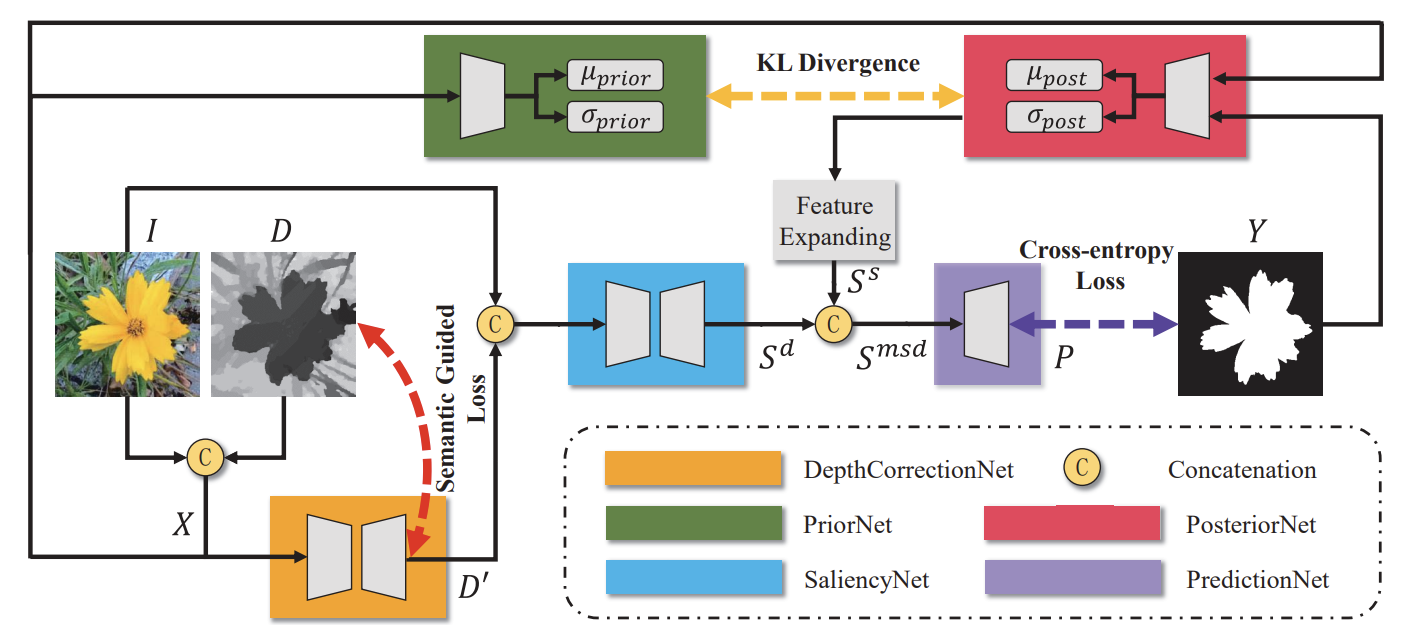

In [ ]:
# ResNet50 with two branches

class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class B2_ResNet(nn.Module):

    def __init__(self):
        # self.inplanes = 128
        self.inplanes = 64
        super(B2_ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(Bottleneck, 64, 3)
        self.layer2 = self._make_layer(Bottleneck, 128, 4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, 256, 6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, 512, 3, stride=2)

        self.inplanes = 512

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x1 = self.layer3(x)
        x1 = self.layer4(x1)

        return x1

In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, dilation=dilation, bias=False)
        self.bn = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Triple_Conv(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Triple_Conv, self).__init__()
        self.reduce = nn.Sequential(
            BasicConv2d(in_channel, out_channel, 1),
            BasicConv2d(out_channel, out_channel, 3, padding=1),
            BasicConv2d(out_channel, out_channel, 3, padding=1)
        )

    def forward(self, x):
        return self.reduce(x)


class Classifier_Module(nn.Module):
    def __init__(self,dilation_series,padding_series,NoLabels, input_channel):
        super(Classifier_Module, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation,padding in zip(dilation_series,padding_series):
            self.conv2d_list.append(nn.Conv2d(input_channel,NoLabels,kernel_size=3,stride=1, padding =padding, dilation = dilation,bias = True))
        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list)-1):
            out += self.conv2d_list[i+1](x)
        return out

In [ ]:
class DenseASPP(nn.Sequential):

    def __init__(self, input_num, num1, num2, dilation_rate, drop_out, bn_start=True):
        super(DenseASPP, self).__init__()
        self.asppconv = torch.nn.Sequential()
        if bn_start:
            self.asppconv = nn.Sequential(
                nn.BatchNorm2d(input_num),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1),
                nn.BatchNorm2d(num1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                          dilation=dilation_rate, padding=dilation_rate)
            )
        else:
            self.asppconv = nn.Sequential(
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=input_num, out_channels=num1, kernel_size=1),
                nn.BatchNorm2d(num1),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=num1, out_channels=num2, kernel_size=3,
                          dilation=dilation_rate, padding=dilation_rate)
            )
        self.drop_rate = drop_out

    def forward(self, _input):
        #feature = super(_DenseAsppBlock, self).forward(_input)
        feature = self.asppconv(_input)

        if self.drop_rate > 0:
            feature = F.dropout2d(feature, p=self.drop_rate, training=self.training)

        return feature


class MultiScaleASPP(nn.Sequential):

    def __init__(self, channel):
        super(MultiScaleASPP, self).__init__()
        self.ASPP_3 = DenseASPP(input_num=channel, num1=channel * 2, num2=channel, dilation_rate=3, drop_out=0.1, bn_start=False)
        self.ASPP_6 = DenseASPP(input_num=channel * 2, num1=channel * 2, num2=channel, dilation_rate=6, drop_out=0.1, bn_start=True)
        self.ASPP_12 = DenseASPP(input_num=channel * 3, num1=channel * 2, num2=channel, dilation_rate=12, drop_out=0.1, bn_start=True)
        self.ASPP_18 = DenseASPP(input_num=channel * 4, num1=channel * 2, num2=channel, dilation_rate=18, drop_out=0.1, bn_start=True)
        self.ASPP_24 = DenseASPP(input_num=channel * 5, num1=channel * 2, num2=channel, dilation_rate=24, drop_out=0.1, bn_start=True)
        self.classification = nn.Sequential(
            nn.Dropout2d(p=0.1),
            nn.Conv2d(in_channels=channel * 6, out_channels=channel, kernel_size=1, padding=0)
        )

    def forward(self, _input):
        #feature = super(_DenseAsppBlock, self).forward(_input)
        aspp3 = self.ASPP_3(_input)
        feature = torch.cat((aspp3, _input), dim=1)

        aspp6 = self.ASPP_6(feature)
        feature = torch.cat((aspp6, feature), dim=1)

        aspp12 = self.ASPP_12(feature)
        feature = torch.cat((aspp12, feature), dim=1)

        aspp18 = self.ASPP_18(feature)
        feature = torch.cat((aspp18, feature), dim=1)

        aspp24 = self.ASPP_24(feature)

        feature = torch.cat((aspp24, feature), dim=1)

        aspp_feat = self.classification(feature)

        return aspp_feat



In [ ]:
## Channel Attention (CA) Layer
class CALayer(nn.Module):

    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
                nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=True),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=True),
                nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y


## Residual Channel Attention Block (RCAB)
class RCAB(nn.Module):

    def __init__(
        self, n_feat, kernel_size=3, reduction=16,
        bias=True, bn=False, act=nn.ReLU(True), res_scale=1):

        super(RCAB, self).__init__()
        modules_body = []
        for i in range(2):
            modules_body.append(self.default_conv(n_feat, n_feat, kernel_size, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            if i == 0: modules_body.append(act)
        modules_body.append(CALayer(n_feat, reduction))
        self.body = nn.Sequential(*modules_body)
        self.res_scale = res_scale

    def default_conv(self, in_channels, out_channels, kernel_size, bias=True):
        return nn.Conv2d(in_channels, out_channels, kernel_size,padding=(kernel_size // 2), bias=bias)

    def forward(self, x):
        res = self.body(x)
        #res = self.body(x).mul(self.res_scale)
        res += x
        return res

In [ ]:
class PredictionNet(nn.Module):

    def __init__(self, channel, latent_dim):
        super(PredictionNet, self).__init__()
        
        self.resnet = B2_ResNet()
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.3)

        self.layer5 = self._make_pred_layer(Classifier_Module, [6, 12, 18, 24], [6, 12, 18, 24], channel, 2048)
        self.layer6 = self._make_pred_layer(Classifier_Module, [6, 12, 18, 24], [6, 12, 18, 24], 1, channel)
        self.layer7 = self._make_pred_layer(Classifier_Module, [6, 12, 18, 24], [6, 12, 18, 24], 1, channel)

        self.upsample8 = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv1 = Triple_Conv(256, channel)
        self.conv2 = Triple_Conv(512, channel)
        self.conv3 = Triple_Conv(1024, channel)
        self.conv4 = Triple_Conv(2048, channel)

        self.asppconv1 = MultiScaleASPP(channel)
        self.asppconv2 = MultiScaleASPP(channel)
        self.asppconv3 = MultiScaleASPP(channel)
        self.asppconv4 = MultiScaleASPP(channel)

        self.spatial_axes = [2, 3]
        self.conv_depth1 = BasicConv2d(6+latent_dim, 3, kernel_size=3, padding=1)

        self.racb_43 = RCAB(channel * 2)
        self.racb_432 = RCAB(channel * 3)
        self.racb_4321 = RCAB(channel * 4)

        self.conv43 = Triple_Conv(2 * channel, channel)
        self.conv432 = Triple_Conv(3 * channel, channel)
        self.conv4321 = Triple_Conv(4 * channel, channel)

        self.conv1_depth = Triple_Conv(256, channel)
        self.conv2_depth = Triple_Conv(512, channel)
        self.conv3_depth = Triple_Conv(1024, channel)
        self.conv4_depth = Triple_Conv(2048, channel)
        self.layer_depth = self._make_pred_layer(Classifier_Module, [6, 12, 18, 24], [6, 12, 18, 24], 3, channel * 4)

        if self.training:
            self.initialize_weights()

    def _make_pred_layer(self, block, dilation_series, padding_series, NoLabels, input_channel):
        return block(dilation_series, padding_series, NoLabels, input_channel)

    def tile(self, a, dim, n_tile):
        """
        This function is taken form PyTorch forum and mimics the behavior of tf.tile.
        Source: https://discuss.pytorch.org/t/how-to-tile-a-tensor/13853/3
        """
        init_dim = a.size(dim)
        repeat_idx = [1] * a.dim()
        repeat_idx[dim] = n_tile
        a = a.repeat(*(repeat_idx))
        order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
        return torch.index_select(a, dim, order_index)

    def forward(self, x, depth, z):

        # encoder part of the DepthCorrectionNet is the same as the “SaliencyNet”
        z = torch.unsqueeze(z, 2)
        z = self.tile(z, 2, x.shape[self.spatial_axes[0]])
        z = torch.unsqueeze(z, 3)
        z = self.tile(z, 3, x.shape[self.spatial_axes[1]])
        x = torch.cat((x, depth, z), 1)
        x = self.conv_depth1(x)
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x1 = self.resnet.layer1(x)  # 256 x 64 x 64
        x2 = self.resnet.layer2(x1)  # 512 x 32 x 32
        x3 = self.resnet.layer3(x2)  # 1024 x 16 x 16
        x4 = self.resnet.layer4(x3)  # 2048 x 8 x 8

        # DepthCorrectionNet
        conv1_depth = self.conv1_depth(x1)
        conv2_depth = self.upsample2(self.conv2_depth(x2))
        conv3_depth = self.upsample4(self.conv3_depth(x3))
        conv4_depth = self.upsample8(self.conv4_depth(x4))
        conv_depth = torch.cat((conv4_depth, conv3_depth, conv2_depth, conv1_depth), 1)
        depth_pred = self.layer_depth(conv_depth)

        # SaliencyNet
        conv1_feat = self.conv1(x1)
        conv1_feat = self.asppconv1(conv1_feat)
        conv2_feat = self.conv2(x2)
        conv2_feat = self.asppconv2(conv2_feat)
        conv3_feat = self.conv3(x3)
        conv3_feat = self.asppconv3(conv3_feat)
        conv4_feat = self.conv4(x4)
        conv4_feat = self.asppconv4(conv4_feat)
        conv4_feat = self.upsample2(conv4_feat)
        conv43 = torch.cat((conv4_feat, conv3_feat), 1)
        conv43 = self.racb_43(conv43)
        conv43 = self.conv43(conv43)
        conv43 = self.upsample2(conv43)
        conv432 = torch.cat((self.upsample2(conv4_feat), conv43, conv2_feat), 1)
        conv432 = self.racb_432(conv432)
        conv432 = self.conv432(conv432)
        conv432 = self.upsample2(conv432)
        conv4321 = torch.cat((self.upsample4(conv4_feat), self.upsample2(conv43), conv432, conv1_feat), 1)
        conv4321 = self.racb_4321(conv4321)
        conv4321 = self.conv4321(conv4321)
        sal_init = self.layer6(conv4321)

        return self.upsample4(sal_init), self.upsample4(depth_pred)

    def initialize_weights(self):
        res50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        pretrained_dict = res50.state_dict()
        all_params = {}
        for k, v in self.resnet.state_dict().items():
            if k in pretrained_dict.keys():
                v = pretrained_dict[k]
                all_params[k] = v
            elif '_1' in k:
                name = k.split('_1')[0] + k.split('_1')[1]
                v = pretrained_dict[name]
                all_params[k] = v
            elif '_2' in k:
                name = k.split('_2')[0] + k.split('_2')[1]
                v = pretrained_dict[name]
                all_params[k] = v
        assert len(all_params.keys()) == len(self.resnet.state_dict().keys())
        self.resnet.load_state_dict(all_params)

## TODO: LatentNet: PriorNet + PosteriorNet

We define $P_\theta(z|X)$ as PriorNet that maps the input RGB-D image pair $X$ to a low-dimensional latent feature space, where $\theta$ is the parameter set of PriorNet. With the same network structure and provided GT saliency map $Y$, we define $Q_\phi(z|X, Y)$ as PosteriorNet, with $\phi$ being the posterior net parameter set. In the LatentNet (PriorNet and PosteriorNet), we use five convolutional layers to map the input RGB-D image $X$ (or concatenation of $X$ and $Y$ for the PosteriorNet) to the latent Gaussian variable $z \sim \mathcal{N}(\mu, diag(\sigma^2))$, where $\mu, \sigma \in \mathbb{R}^K$, representing the mean and standard deviation of the latent Gaussian variable.

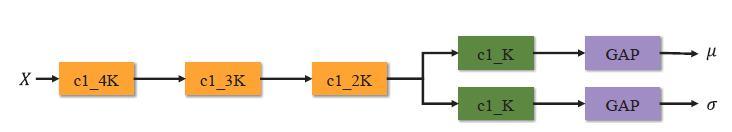

In [ ]:
class PriorNet(nn.Module):

    def __init__(self, input_channels, channels, latent_size):
        super(PriorNet, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.input_channels = input_channels
        self.channel = channels
        
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU()
        
        # TODO: create convolutional layers and fully connected layers

    def forward(self, x):
        
        # TODO: apply convolutional layers
        
        output = output.view(-1, self.channel * 8 * 11 * 11)

        # TODO: apply fully connected layers
        
        mu = None  # TODO
        logvar = None  # TODO
        dist = Independent(Normal(loc=mu, scale=torch.exp(logvar)), 1)

        return dist, mu, logvar


class PosteriorNet(nn.Module):

    def __init__(self, input_channels, channels, latent_size):
        super(PosteriorNet, self).__init__()
        self.contracting_path = nn.ModuleList()
        self.input_channels = input_channels
        self.channel = channels
        
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU()
        
        # TODO: create convolutional layers and fully connected layers

    def forward(self, x):
        
        # TODO: apply convolutional layers
        
        output = output.view(-1, self.channel * 8 * 11 * 11)

        # TODO: apply fully connected layers
        
        mu = None  # TODO
        logvar = None  # TODO
        dist = Independent(Normal(loc=mu, scale=torch.exp(logvar)), 1)

        return dist, mu, logvar

In [ ]:
class UCNet(nn.Module):

    def __init__(self, channel, latent_dim):
        super(UCNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.sal_encoder = PredictionNet(channel, latent_dim)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.xy_encoder = None  # TODO
        self.x_encoder  = None  # TODO
        self.tanh = nn.Tanh()

    def _make_pred_layer(self, block, dilation_series, padding_series, NoLabels, input_channel):
        return block(dilation_series, padding_series, NoLabels, input_channel)

    def kl_divergence(self, posterior_latent_space, prior_latent_space):
        kl_div = kl.kl_divergence(posterior_latent_space, prior_latent_space)
        return kl_div

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(std.size()).normal_().to(device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x, depth, y=None, training=True):
        if training:
            self.posterior, muxy, logvarxy = self.xy_encoder(torch.cat((x,depth,y),1))
            self.prior, mux, logvarx = self.x_encoder(torch.cat((x,depth),1))
            lattent_loss = torch.mean(self.kl_divergence(self.posterior, self.prior))
            z_noise_post = self.reparametrize(muxy, logvarxy)
            z_noise_prior = self.reparametrize(mux, logvarx)
            self.prob_pred_post,  self.depth_pred_post  = self.sal_encoder(x, depth, z_noise_post)
            self.prob_pred_prior, self.depth_pred_prior = self.sal_encoder(x, depth, z_noise_prior)
            return self.prob_pred_post, self.prob_pred_prior, lattent_loss, self.depth_pred_post, self.depth_pred_prior
        else:
            _, mux, logvarx = self.x_encoder(torch.cat((x,depth),1))
            z_noise = self.reparametrize(mux, logvarx)
            self.prob_pred, _ = self.sal_encoder(x,depth,z_noise)
            return self.prob_pred


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

In [ ]:
# initialize the network
feat_channel = 32
latent_dim = 3
model = UCNet(channel=feat_channel, latent_dim=latent_dim)
model = model.to(device)
print(model)

In [ ]:
# model summary
image = torch.stack(imgs).to(device)
depth = torch.stack(depths).to(device)
res = model.forward(image, depth, training=False)
res = F.interpolate(res, size=[dataset.imsize, dataset.imsize], mode='bilinear', align_corners=False).sigmoid()
graph = make_dot(res.mean(), params=dict(model.named_parameters()))
#graph.render("graph", format="png")
graph

graph

# Optimizer

In [ ]:
# Model Hyperparameters
EPOCHS = 100
LEARNING_RATE = 5e-5
BATCH_SIZE = 10

BETA_1 = 0.5
BETA_2 = 0.999

DECAY_RATE = 0.9
DECAY_EPOCH = 80

WEIGHT_DECAY = 0.001

SM_WEIGHT = 0.1
REG_WEIGHT = 1e-4
LAT_WEIGHT = 10.0
VAE_LOSS_WEIGHT = 0.4
DEPTH_LOSS_WEIGHT = 0.1

In [ ]:
# Defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=[BETA_1, BETA_2])

In [ ]:
# l2 regularization
def l2_regularisation(m):
    l2_reg = None

    for W in m.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return l2_reg

# Loss function

In [ ]:
CE = torch.nn.BCELoss

In [ ]:
mse_loss = torch.nn.MSELoss(reduction='mean')

In [ ]:
def structure_loss(pred, mask):

    weit  = 1+5*torch.abs(F.avg_pool2d(mask, kernel_size=31, stride=1, padding=15)-mask)
    wbce  = F.binary_cross_entropy_with_logits(pred, mask, reduce='none')
    wbce  = (weit*wbce).sum(dim=(2,3))/weit.sum(dim=(2,3))

    pred  = torch.sigmoid(pred)
    inter = ((pred*mask)*weit).sum(dim=(2,3))
    union = ((pred+mask)*weit).sum(dim=(2,3))
    wiou  = 1-(inter+1)/(union-inter+1)

    return (wbce+wiou).sum()

In [ ]:
def smoothness_loss(pred, target):

    def laplacian_edge(img):
        laplacian_filter = torch.Tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
        filter = torch.reshape(laplacian_filter, [1, 1, 3, 3])
        filter = filter.to(device)
        lap_edge = F.conv2d(img, filter, stride=1, padding=1)
        return lap_edge

    def gradient_x(img):
        sobel = torch.Tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        filter = torch.reshape(sobel,[1,1,3,3])
        filter = filter.to(device)
        gx = F.conv2d(img, filter, stride=1, padding=1)
        return gx

    def gradient_y(img):
        sobel = torch.Tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        filter = torch.reshape(sobel, [1, 1,3,3])
        filter = filter.to(device)
        gy = F.conv2d(img, filter, stride=1, padding=1)
        return gy

    def charbonnier_penalty(s):
        cp_s = torch.pow(torch.pow(s, 2) + 0.001**2, 0.5)
        return cp_s

    alpha = 10
    s1 = 10
    s2 = 0
    ## first oder derivative: sobel
    sal_x = torch.abs(gradient_x(pred))
    sal_y = torch.abs(gradient_y(pred))
    gt_x = gradient_x(target)
    gt_y = gradient_y(target)
    w_x = torch.exp(torch.abs(gt_x) * (-alpha))
    w_y = torch.exp(torch.abs(gt_y) * (-alpha))
    cps_x = charbonnier_penalty(sal_x * w_x)
    cps_y = charbonnier_penalty(sal_y * w_y)
    cps_xy = cps_x + cps_y

    ## second order derivative: laplacian
    lap_sal = torch.abs(laplacian_edge(pred))
    lap_gt = torch.abs(laplacian_edge(target))
    weight_lap = torch.exp(lap_gt * (-alpha))
    weighted_lap = charbonnier_penalty(lap_sal*weight_lap)

    smooth_loss = s1*torch.mean(cps_xy) + s2*torch.mean(weighted_lap)

    return smooth_loss


# Training

In [ ]:
# linear annealing to avoid posterior collapse
def linear_annealing(init, fin, step, annealing_steps):
    """Linear annealing of a parameter."""
    if annealing_steps == 0:
        return fin
    assert fin > init
    delta = fin - init
    annealed = min(init + delta * step / annealing_steps, fin)
    return annealed

In [ ]:
# learning rate update
def adjust_lr(optimizer, init_lr, epoch, decay_rate=0.1, decay_epoch=5):
    decay = decay_rate ** (epoch // decay_epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay

In [ ]:
# Initializing pytorch dataloader
train_loader = data.DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True)
training_set_size = dataset.size
total_step = len(train_loader)

In [ ]:
load_trained = True

In [ ]:
if load_trained:

    url = "https://drive.google.com/uc?id=1BskYx06A6GQxn-VLp1dKfMzo6B6psB5G"
    filename = "UCNet.pth"
    if not os.path.exists(filename):
        gdown.download(url, filename, quiet=False)
    model.load_state_dict(torch.load(filename, map_location=device))

else:

    for epoch in range(1, EPOCHS+1):

        print('Generator Learning Rate: {}'.format(optimizer.param_groups[0]['lr']))

        for i, pack in enumerate(train_loader, start=1):

            images, gts, depths, index_batch = pack
            # print(index_batch)

            images = Variable(images)
            gts = Variable(gts)
            depths = Variable(depths)

            images = images.to(device)
            gts = gts.to(device)
            depths = depths.to(device)

            # forward
            pred_post, pred_prior, latent_loss, depth_pred_post, depth_pred_prior = model.forward(images, depths, gts)

            # reg loss
            reg_loss = l2_regularisation(model.xy_encoder) + l2_regularisation(model.x_encoder) + l2_regularisation(model.sal_encoder)
            reg_loss = REG_WEIGHT * reg_loss

            # latent loss
            latent_loss = latent_loss
            anneal_reg = linear_annealing(0, 1, epoch, EPOCHS)
            latent_loss = LAT_WEIGHT * anneal_reg * latent_loss

            # smoothness loss post
            smoothLoss_post = SM_WEIGHT * smoothness_loss(torch.sigmoid(pred_post), gts)
            depth_loss_post = DEPTH_LOSS_WEIGHT * mse_loss(torch.sigmoid(depth_pred_post),depths)
            sal_loss = structure_loss(pred_post, gts) + smoothLoss_post + depth_loss_post

            # smoothness loss prior
            smoothLoss_prior = SM_WEIGHT * smoothness_loss(torch.sigmoid(pred_prior), gts)
            depth_loss_prior = DEPTH_LOSS_WEIGHT * mse_loss(torch.sigmoid(depth_pred_prior),depths)
            gen_loss_gsnn = structure_loss(pred_prior, gts) + smoothLoss_prior + depth_loss_prior

            # combine losses
            gen_loss_cvae = sal_loss + latent_loss
            gen_loss_cvae = VAE_LOSS_WEIGHT * gen_loss_cvae
            gen_loss_gsnn = (1.0 - VAE_LOSS_WEIGHT) * gen_loss_gsnn
            gen_loss = gen_loss_cvae + gen_loss_gsnn + reg_loss

            # optimize
            optimizer.zero_grad()
            gen_loss.backward()
            optimizer.step()

            visualize_gt(gts)
            visualize_uncertainty_post_init(torch.sigmoid(pred_post))
            visualize_uncertainty_prior_init(torch.sigmoid(pred_prior))

            if i % 10 == 0 or i == total_step:

                print('{} Epoch [{:03d}/{:03d}], Step [{:04d}/{:04d}], gen vae Loss: {:.4f}, gen gsnn Loss: {:.4f}, reg Loss: {:.4f}'.
                      format(datetime.now(), epoch, EPOCHS, i, total_step, gen_loss_cvae.data, gen_loss_gsnn.data, reg_loss.data))
                # print(anneal_reg)

        adjust_lr(model, LEARNING_RATE, epoch, DECAY_RATE, DECAY_EPOCH)

        save_path = 'models/'

        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if epoch % 50 == 0:
            torch.save(model.state_dict(), save_path + 'Model' + '_%d' % epoch + '_gen.pth')


# Inference

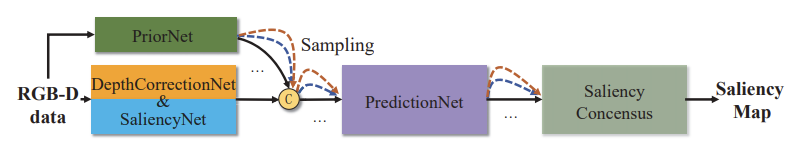

In [ ]:
# Get the test data
benchmarks = SalObjDataset('dataset', 'test', download=True)
print(f'Test samples: {len(benchmarks)}')

In [ ]:
# Set the model to eval state
model = model.eval()

In [ ]:
# Display some sample images and their salency map
imgs = []
gts = []
depths = []
cols, rows = 5, 1
for i in range(cols * rows):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, gt, depth = benchmarks.get(sample_idx)
    imgs.append(img)
    gts.append(gt)
    depths.append(depth)

display_image_grid(imgs, rows, cols, "Image")
display_image_grid(depths, rows, cols, "Depth")
display_image_grid(gts, rows, cols, "Ground truth")

with torch.no_grad():
    image = torch.stack(imgs).to(device)
    depth = torch.stack(depths).to(device)
    res = model.forward(image, depth, training=False)
    res = F.interpolate(res, size=[benchmarks.imsize, benchmarks.imsize], mode='bilinear', align_corners=False).sigmoid()
    res = res.cpu()

display_image_grid(res, rows, cols, "Predictions")